In [1]:
# Import relevant packages
import gurobipy as gp                 # Gurobi Python API
from gurobipy import GRB              # Gurobi constants (e.g., GRB.MAXIMIZE)

import pandas as pd                   # DataFrames
import matplotlib.pyplot as plt       # Plotting
from matplotlib.lines import Line2D
import numpy as np                    # Numerical operations (similar to Julia base)

import warnings
warnings.filterwarnings("ignore", message=".*All values for SymLogScale are below linthresh.*")

In [2]:
# Import auxiliary functions
from functions_data import *
from functions_model import *
from functions_plots import *
from functions_policy import *

In [3]:
from main import main

In [4]:
def plot_market_price_summary(results, x_label, x_values, season="Winter", selected_hours=[], save=False):
    avg_prices, peak_prices, weighted_avg_prices = [], [], []
    hour_prices = {h: [] for h in selected_hours}

    for n in x_values:
        output = results[season][n]
        price = output[0][3]

        avg_prices.append(np.mean(price))
        peak_prices.append(np.max(price))
        for h in selected_hours:
            hour_prices[h].append(price[h])

        discharge = [sum(output[p][1][t] for p in output) for t in range(len(price))]
        weighted_avg_prices.append(np.average(price, weights=discharge))

    plt.figure(figsize=(10, 6))
    plt.plot(x_values, avg_prices, 'o-', label="Average Price")
    plt.plot(x_values, peak_prices, 'o-', label="Peak Price")
    plt.plot(x_values, weighted_avg_prices, 'o-', label="Weighted Avg Price")

    for i in range(len(x_values)):
        plt.text(x_values[i], avg_prices[i] * 1.1, f"{avg_prices[i]:.2f}", ha='center', va='bottom', fontsize=9)
        plt.text(x_values[i], peak_prices[i] * 1.03, f"{peak_prices[i]:.2f}", ha='center', va='bottom', fontsize=9)
        plt.text(x_values[i], weighted_avg_prices[i] * 1.05, f"{weighted_avg_prices[i]:.2f}", ha='center', va='bottom', fontsize=9)

    for h in selected_hours:
        plt.plot(x_values, hour_prices[h], 'o--', label=f"Price at {h}:00")

    plt.xlabel(f"{x_label}")
    plt.ylabel("Market Price [€/MWh]")
    plt.ylim(top=max(peak_prices)*1.1)
    plt.title(f"Market Price Summary - {season}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f"figs_policies/market_price_summary_{season}.pdf")
        results_df = pd.DataFrame({
            "average_prices": avg_prices,
            "weighted_average_prices": np.insert(weighted_avg_prices, 0, 0),
            "peak_prices": peak_prices
        })
        results_df.to_csv(f"csv_policies\{season}-market_summary.csv")
    plt.show()


In [5]:
def plot_stacked_welfare(results, x_label, x_values, season="Winter", save=False):
    cs_list, ps_list = [], []
    for n in x_values:
        output = results[season][n]
        cs_list.append(sum(output[0][7])/1e3)
        ps_list.append(sum(output[0][8])/1e3)

    ind = np.arange(start=1, stop=1+len(x_values))
    width = 0.6

    plt.figure(figsize=(8, 5))
    plt.bar(ind, cs_list, width, label='Consumer Surplus', color='skyblue')
    plt.bar(ind, ps_list, width, bottom=cs_list, label='Producer Surplus', color='orange')
    plt.xticks(ind, x_values)
    plt.xlabel(f"{x_label}")
    plt.ylabel("Monetary Value [thousands €]")
    plt.title(f"Evolution of Market Welfare - {season}")
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f"figs_policies/stacked_surplus_{season}.pdf")
        results_df = pd.DataFrame({
            "consumer_surplus": cs_list,
            "producer_surplus": ps_list
        })
        results_df.to_csv(f"csv_policies\{season}-welfare_metrics.csv")
    plt.show()


In [6]:
def plot_curtail_unmet_groupedbars(results, x_label, x_values, season="Winter", save=False):
    curtailed, unmet = [], []
    for n in x_values:
        output = results[season][n]
        curtailed.append(np.mean(output[0][10]))
        unmet.append(np.mean(output[0][9]))

    x = np.arange(start=1, stop=1+len(x_values))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    bar1 = ax.bar(x - width/2, curtailed, width, label='Curtailed Energy', color='salmon')
    bar2 = ax.bar(x + width/2, unmet, width, label='Unmet Demand', color='steelblue')

    ax.set_xlabel(f"{x_label}")
    ax.set_ylabel("Energy [MWh]")
    ax.set_title(f"Curtailed and Unmet Energy - {season}")
    ax.set_xticks(x)
    ax.set_xticklabels(x_values)
    ax.legend(loc='lower left')
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Add text annotations
    for bars in [bar1, bar2]:
        for bar in bars:
            height = bar.get_height()
            offset = max(0.01 * max(curtailed + unmet), 0.05)  # adaptive offset
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + offset,
                f"{height:.1f}",
                ha='center', va='bottom',
                fontsize=9
            )
    ax.set_ylim(top=max(curtailed)*1.05, bottom=min(unmet)*0.8)

    plt.tight_layout()
    if save:
        plt.savefig(f"figs_policies/curtailment_unmet_grouped_{season}.pdf")
    plt.show()

In [7]:
def plot_curtailment_and_unmet_subplots(results, x_label, x_values, season="Winter", mode="Total", save=False):
    curtailed, unmet = [], []
    curtailed_total, curtailed_average, unmet_total, unmet_average = [], [], [], []
    for n in x_values:
        output = results[season][n]

        curtailed_total.append(sum(output[0][10]))
        unmet_total.append(sum(output[0][9]))
        curtailed_average.append(np.mean(output[0][10]))
        unmet_average.append(np.mean(output[0][9]))

    if mode == "Total":
        curtailed = curtailed_total
        unmet = unmet_total
    else:
        curtailed = curtailed_average
        unmet = unmet_average

    x = np.arange(len(x_values))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

    # --- Curtailed Energy ---
    bars1 = ax1.bar(x, curtailed, color='salmon')
    ax1.set_title(f"{mode} Curtailed Energy")
    ax1.set_xlabel(f"{x_label}")
    ax1.set_ylabel("Energy [MWh]")
    ax1.set_ylim(top=max(curtailed)*1.05, bottom=min(curtailed)*0.75)
    ax1.set_xticks(x)
    ax1.set_xticklabels(x_values)
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    for bar in bars1:
        height = bar.get_height()
        offset = max(0.01 * max(curtailed), 0.05)
        ax1.text(bar.get_x() + bar.get_width()/2, height + offset,
                 f"{height:.1f}", ha='center', va='bottom', fontsize=9)

    # --- Unmet Demand ---
    bars2 = ax2.bar(x, unmet, color='steelblue')
    ax2.set_title(f"{mode} Unmet Demand")
    ax2.set_xlabel(f"{x_label}")
    ax2.set_xticks(x)
    ax2.set_xticklabels(x_values)
    ax2.set_ylim(top=max(unmet)*1.1, bottom=min(unmet)*0.5)
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    for bar in bars2:
        height = bar.get_height()
        offset = max(0.01 * max(unmet), 0.05)
        ax2.text(bar.get_x() + bar.get_width()/2, height + offset,
                 f"{height:.1f}", ha='center', va='bottom', fontsize=9)

    fig.suptitle(f"Evolution of Market Flexibility Metrics - {season}", fontsize=14)
    # plt.tight_layout()
    
    if save:
        plt.savefig(f"figs_policies/curtailment_unmet_{mode}_{season}.pdf")
        results_df = pd.DataFrame({
            "curtailement-average": curtailed_average,
            "unmet_demand-average": unmet_average,
            "curtailement-total": curtailed_total,
            "unmet_demand-total": unmet_total           
        })
        results_df.to_csv(f"csv_policies\{season}-flexibility_metrics.csv")
    plt.show()


In [8]:
def plot_revenue_per_mwh(results, x_label, x_values, season="Winter", save=False):
    rev_per_mwh = []
    weighted_avg_rev_per_mwh = []
    rev_per_capacity = []

    capacity = {
        "Winter": 6330.0,
        "Summer": 11520.0,
        "LowLoad": 9140.0
    }

    for n in x_values:
        output = results[season][n]

        total_rev, total_dis = 0, 0
        for p in output:
            revenue = sum(output[p][4])
            discharged = sum(output[p][1])
            total_rev += revenue
            total_dis += discharged
        avg = total_rev / total_dis if total_dis > 0 else 0
        rev_per_mwh.append(avg)
        rev_per_capacity.append(total_rev / capacity[season])

        revenue, discharged = [], []
        for t in range(24):
            revenue.append(sum(output[p][4][t] for p in output))
            discharged.append(sum(output[p][1][t] for p in output))
        weighted_avg_rev_per_mwh.append(np.average(revenue, weights=discharged))


    plt.figure(figsize=(8, 5))
    plt.plot(x_values, rev_per_mwh, 'o-', color='darkgreen', label='Revenue per MWh')
    plt.plot(x_values, rev_per_capacity, 'o-', label='Revenue per Capacity')
    # plt.plot(x_values, weighted_avg_rev_per_mwh, 'o-', label='Weighted Average Revenue per MWh')

    for i, val in enumerate(rev_per_mwh):
        plt.text(x_values[i], val*1.03, f"{val:.1f}", ha='center', va='bottom', fontsize=9)
    for i, val in enumerate(rev_per_capacity):
        plt.text(x_values[i], val*1.1, f"{val:.2f}", ha='center', va='bottom', fontsize=9)
    # for i, val in enumerate(weighted_avg_rev_per_mwh):
    #     plt.text(x_values[i], val*1.01, f"{val:.1f}", ha='center', va='bottom', fontsize=9)
    
    bottom, top = plt.ylim()
    plt.ylim(top=1.15*top)

    plt.xlabel(f"{x_label}")
    plt.ylabel("Revenue [€/MWh]")
    plt.title(f"Average Revenue Summary - {season}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    if save:
        plt.savefig(f"figs_policies/revenue_summary_{season}.pdf")
    plt.show()


In [9]:
def plot_total_discharge(results, x_label, x_values, season="Winter", save=False):
    total_discharge = []

    for n in x_values:
        output = results[season][n]
        total_dis = sum(sum(output[p][1]) for p in output)
        total_discharge.append(total_dis)

    plt.figure(figsize=(8, 5))
    plt.plot(x_values, total_discharge, 'o-', color='slateblue')
    plt.xlabel(f"{x_label}")
    plt.ylabel("Total Energy Discharged [MWh]")
    plt.title(f"Total Discharge - {season}")
    plt.grid(True)

    # Dynamic y-axis and text settings
    sorted_vals = sorted(total_discharge)
    if len(sorted_vals) >= 2 and abs(sorted_vals[-1] - sorted_vals[0]) < 1:
        # Minor differences in values → Using linear y-scale
        plt.ylim(bottom=sorted_vals[0]-1, top=sorted_vals[-1]+1)
        for i, val in enumerate(total_discharge):
            plt.text(x_values[i], val+0.1, f"{val:.1f}", ha='center', va='bottom', fontsize=9)
    # elif len(sorted_vals) >= 2 and sorted_vals[-1] > 1.5 * sorted_vals[-2]:
    #     # Outlier value → Using symlog y-scale with linthresh = {linthresh:.1f}
    #     linthresh = sorted_vals[-2] * 1.2  # Small buffer above 2nd-largest
    #     plt.yscale('symlog', linthresh=linthresh)
    else:
        # Usual case → Using linear y-scale
        plt.ylim(top=sorted_vals[-1]*1.05)
        for i, val in enumerate(total_discharge):
            plt.text(x_values[i], val * 1.02, f"{val:.1f}", ha='center', va='bottom', fontsize=9)

    
    plt.tight_layout()

    if save:
        plt.savefig(f"figs_policies/total_discharge_{season}.pdf")
        results_df = pd.DataFrame({
            "total_discharge": total_discharge        
        })
        results_df.to_csv(f"csv_policies\{season}-storage_discharge.csv")
    plt.show()


# POLICY MODELLING
## Grid Tariffs 

In [10]:
scenarios = [
    {"name": "baseline", "policy_type": "none"},
    {"name": "flat_tariff", "policy_type": "grid_tariff_flat", "tau_ch": 4.0, "tau_dis": 2.0},
    {"name": "hourly_tariff", "policy_type": "grid_tariff_hourly", "min_val": 2.0, "max_val": 5.0},
    {"name": "dynamic_tariff", "policy_type": "grid_tariff_dynamic", "alpha": 0.001, "base_tariff": 5.0, "floor_tariff": 2.0}
]

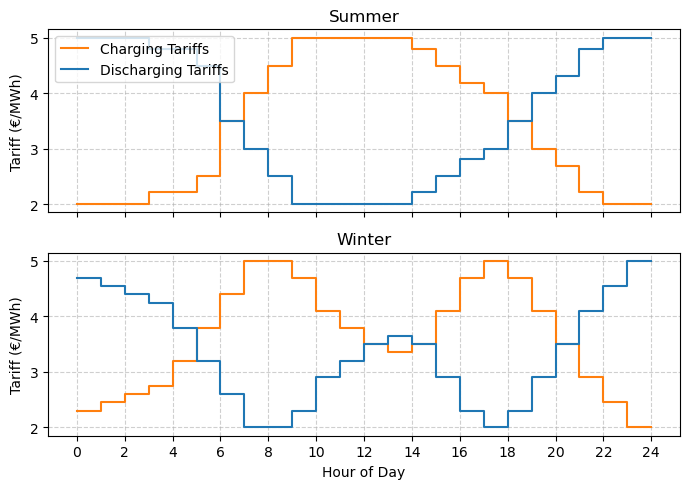

In [11]:
# Hourly Tariffs
hourly_scenario = [scen for scen in scenarios if scen['name']=="hourly_tariff"]
min_val = hourly_scenario[0].get("min_val", 2.0)
max_val = hourly_scenario[0].get("max_val", 5.0)    

tau_ch_hourly_summer = generate_hourly_tariff_vector('charging', 'Summer', min_val, max_val)
tau_dis_hourly_summer = generate_hourly_tariff_vector('discharging', 'Summer', min_val, max_val)
tau_ch_hourly_winter = generate_hourly_tariff_vector('charging', 'Winter', min_val, max_val)
tau_dis_hourly_winter = generate_hourly_tariff_vector('discharging', 'Winter', min_val, max_val)

fig, axs = plt.subplots(2,1,figsize=(7, 5), sharex=True)
axs[0].step(range(25), tau_ch_hourly_summer+[tau_ch_hourly_summer[-1]], where='post', label='Charging Tariffs', color='tab:orange')
axs[0].step(range(25), tau_dis_hourly_summer+[tau_dis_hourly_summer[-1]], where='post', label='Discharging Tariffs', color='tab:blue')
axs[0].set_title("Summer")
# axs[0].set_xlabel("Hour of Day")
axs[0].set_ylabel("Tariff (€/MWh)")
axs[0].grid(True, linestyle='--', alpha=0.6)
axs[0].legend(loc='upper left')

axs[1].step(range(25), tau_ch_hourly_winter+[tau_ch_hourly_winter[-1]], where='post', label='Charging Tariffs', color='tab:orange')
axs[1].step(range(25), tau_dis_hourly_winter+[tau_dis_hourly_winter[-1]], where='post', label='Discharging Tariffs', color='tab:blue')
axs[1].set_title("Winter")
axs[1].set_xlabel("Hour of Day")
axs[1].set_ylabel("Tariff (€/MWh)")
axs[1].grid(True, linestyle='--', alpha=0.6)
# axs[1].legend(loc='upper right')
axs[1].set_xticks(range(25))

axs[0].set_xticks(np.arange(0,25,2))
plt.tight_layout()
plt.savefig("figs_policies/hourly_tariffs.pdf")

plt.show()

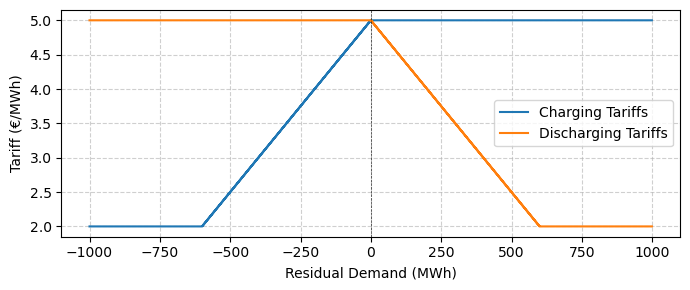

In [12]:
# Dynamic Tariffs
dynamic_scenario = [scen for scen in scenarios if scen['name']=="dynamic_tariff"]
alpha = dynamic_scenario[0].get("alpha", 0.001)
threshold = dynamic_scenario[0].get("threshold", 0.0)
base_tariff = dynamic_scenario[0].get("base_tariff", 5.0)
floor_tariff = dynamic_scenario[0].get("floor_tariff", 2.0)

residual_serie = np.arange(-1000,1000)
tau_ch_dynamic = compute_charging_tariff_from_residual_demand(residual_serie, alpha, threshold, base_tariff, floor_tariff)
tau_dis_dynamic = compute_discharging_tariff_from_residual_demand(residual_serie, alpha, threshold, base_tariff, floor_tariff)

plt.figure(figsize=(7, 3))
plt.step(residual_serie, tau_ch_dynamic, where='mid', label='Charging Tariffs')
plt.step(residual_serie, tau_dis_dynamic, where='mid', label='Discharging Tariffs')
# plt.title("Dynamic Tariffs")
plt.xlabel("Residual Demand (MWh)")
# plt.ylim(bottom=0)
plt.axvline(x=0, color='black', alpha=0.8, linestyle='--', linewidth=0.5)
plt.ylabel("Tariff (€/MWh)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig("figs_policies/dynamic_tariffs.pdf")


# Analysis of grid tariffs

In [20]:
def plot_scenarios_analysis(outputs, model_parameters=None, plots=False):
    """
    Generate comparative plots of market and player metrics across multiple policy scenarios.

    Parameters:
        outputs (dict):
            Dictionary mapping scenario names (str) to output data dictionaries.
            Each output dict is indexed by player and contains lists of time series data.
    """
    if model_parameters:
        [max_iter, TIME, T, D, N, RES, Demand_volume, Demand_price, diff_table_initial] = model_parameters

    scenario_names = list(outputs.keys())
    n_scenarios = len(scenario_names)
    scenario_colors = mpl.color_sequences['tab10'][:n_scenarios]
    scenario_linestyles = ['-', ':', '--', '-.', ''][:n_scenarios]
    n_players = len(outputs[scenario_names[0]])
    T = len(outputs[scenario_names[0]][0][3])
    TIME = range(T)
    TIME_adjusted = range(T+1)
    
    # --- 1) Market price over time ---
    plt.figure(figsize=(8,4))
    for j, scen in enumerate(scenario_names):
        # Price is same across players, take player 0 for reference
        price = outputs[scen][0][3]  
        plt.step(TIME_adjusted, list(price)+[price[-1]], label=scen, color=scenario_colors[j], linestyle=scenario_linestyles[j], where='post')
    plt.title("Market Price Over Time")
    plt.xlabel("Hour")
    plt.ylabel("Price (€/MWh)")
    plt.legend()
    plt.grid()

    plt.tight_layout()

    if plots:
        plt.savefig("figs_policies/tariffs_prices.pdf")

    # --- 2) Unmet demand over time ---
    plt.figure(figsize=(8,4))
    for j, scen in enumerate(scenario_names):
        unmet = outputs[scen][0][9]
        plt.step(TIME_adjusted, list(unmet)+[unmet[-1]], label=scen, color=scenario_colors[j], linestyle=scenario_linestyles[j], where='post')
    plt.title("Unmet Demand Over Time")
    plt.xlabel("Hour")
    plt.ylabel("Unmet Demand (MW)")
    plt.legend()
    plt.grid()

    plt.tight_layout()

    if plots:
        plt.savefig("figs_policies/tariffs_unmetdemand.pdf")

    # # --- 3) Curtailed production over time ---
    # plt.subplot(2,2,3)
    # for j, scen in enumerate(scenario_names):
    #     curtailed = outputs[scen][0][10]
    #     plt.step(TIME, curtailed, label=scen, color=scenario_colors[j])
    # plt.title("Curtailed Production Over Time")
    # plt.xlabel("Time")
    # plt.ylabel("Curtailed Production (MW)")
    # plt.legend()
    # plt.grid()

    # --- 3) Charging behavior over time ---
    plt.figure(figsize=(8,4))
    for i, scen in enumerate(scenario_names):
        output = outputs[scen]
        total_q_ch = [sum(output[p][0][t] for p in range(n_players)) for t in TIME]
        plt.step(TIME_adjusted, list(total_q_ch)+[total_q_ch[-1]], where='post', label=scen, color=scenario_colors[i], linestyle=scenario_linestyles[i])

    plt.title("Total Charging Behavior Across Scenarios")
    plt.xlabel("Hour")
    plt.ylabel("Charging Power [MW]")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    if plots:
        plt.savefig("figs_policies/tariffs_charging.pdf")

    # --- 4) Profits per player grouped bar chart ---
    # Build matrix of profits: shape (n_players, n_scenarios)
    profits_matrix = np.zeros((n_players, n_scenarios))
    policy_addon = np.zeros((n_players, n_scenarios))
    for j, scen in enumerate(scenario_names):
        for p in range(n_players):
            # sum revenue as profit proxy, or have dedicated profit in outputs if available
            profits_matrix[p, j] = sum(outputs[scen][p][4])  # sum over time of revenue
            policy_addon[p, j] = sum(outputs[scen][p][5])  # sum over time of revenue

    # Plot grouped bar chart
    bar_width = 0.15
    x = np.arange(n_players)

    plt.figure(figsize=(8,4))
    for i, scen in enumerate(scenario_names):
        plt.bar(x + i*bar_width, profits_matrix[:, i], width=bar_width, label=f'{scen} Base Revenue', color=scenario_colors[i], edgecolor='black')
        plt.bar(x + i*bar_width, policy_addon[:, i], width=bar_width, bottom=profits_matrix[:, i], label=f'{scen} Tariff Cost', hatch='//', color='gray', edgecolor='black')

    # Create custom legend for scenarios
    scenario_handles = [Patch(color=scenario_colors[i], label=scenario_names[i]) for i in range(n_scenarios)]

    # Create custom legend for revenue types
    type_handles = [
        # Patch(facecolor='gray', edgecolor='black', label='Market revenue'),
        Patch(facecolor='gray', edgecolor='black', hatch='//', label='tariff cost')
    ]

    # # First legend
    # leg1 = plt.legend(handles=scenario_handles, loc='upper left')
    # # Second legend, added manually
    # leg2 = plt.legend(handles=type_handles, loc='upper right')
    # ax = plt.gca()
    # ax.add_artist(leg1)
    plt.legend(handles=scenario_handles + type_handles, loc="upper left", ncol=2)


    plt.xticks(x + bar_width * (n_scenarios - 1) / 2, [f'Player {p+1}' for p in range(n_players)])
    plt.ylabel("Total Profit (€)")
    plt.ylim(top=1.1*np.max(profits_matrix))
    plt.title("Player Profits by Scenario")
    plt.grid(axis='y')

    plt.tight_layout()

    if plots:
        plt.savefig("figs_policies/tariffs_profits.pdf")


    # --- Other subplot: Revenue over time (aggregated over players) ---
    bar_width = 0.8 / n_scenarios
    x = np.arange(len(TIME))

    plt.figure(figsize=(8, 5))

    for j, scen in enumerate(scenario_names):
        # Aggregate over players
        base_revenue = np.sum([outputs[scen][p][4] for p in range(n_players)], axis=0)
        tariff_addon = np.sum([outputs[scen][p][5] for p in range(n_players)], axis=0)

        x_offset = x - 0.4 + j * bar_width

        plt.bar(x_offset, base_revenue, width=bar_width, label=f"{scen} Base", color=scenario_colors[j], edgecolor='black')
        plt.bar(x_offset, tariff_addon, width=bar_width, bottom=base_revenue, 
                label=f"{scen} Tariff", hatch='//', color='gray', edgecolor='black')

    plt.xlabel("Time (Hour)")
    plt.ylabel("Revenue (€)")
    plt.title("Scenario Comparison: Revenue and Tariff Component per Hour")
    plt.xticks(x, [str(t) for t in TIME])
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)

    # Custom legend: one per scenario and one for tariff layer
    scenario_legend = [Patch(color=scenario_colors[i], label=scenario_names[i]) for i in range(n_scenarios)]
    tariff_legend = [Patch(facecolor='gray', hatch='//', label="tariff cost", edgecolor='black')]
    plt.legend(handles=scenario_legend + tariff_legend, loc="upper right", ncol=2)
    plt.tight_layout()

    if plots:
        plt.savefig("figs_policies/tariffs-players_revenue.pdf")


    # --- Tariffs Plots ---

    # # Plot tariffs
    # plt.figure(figsize=(10, 3))
    # plt.step(range(24), tau_ch, where='mid')
    # plt.step(range(24), tau_dis, where='mid')
    # plt.step(range(24), residual_series, where='mid', color='red', linestyle='--')
    # plt.title("Dynamic Tariffs (€/MWh)")
    # plt.xlabel("Time (h)")
    # plt.ylabel("Tariff")
    # plt.grid(True, linestyle='--', alpha=0.6)
    # plt.xticks(range(24))
    # plt.tight_layout()



## Winter Scenario


Optimization with modelling policy: baseline
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   630.0   316.0   
1      B  0.5  0.85  1260.0   633.0   
2      C  0.5  0.85  1900.0   950.0   
3      D  0.5  0.85  2530.0  1267.0   

                                             Q_steps  
0  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
1  [0.0, 63.3, 126.6, 189.9, 253.2, 316.5, 379.8,...  
2  [0.0, 95.0, 190.0, 285.0, 380.0, 475.0, 570.0,...  
3  [0.0, 126.7, 253.4, 380.1, 506.8, 633.5, 760.2...  
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-28
Optimization was successful. It converged in 8 iterations.


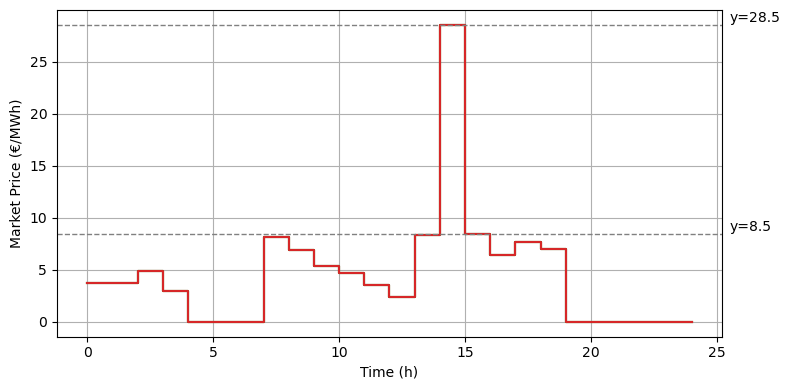

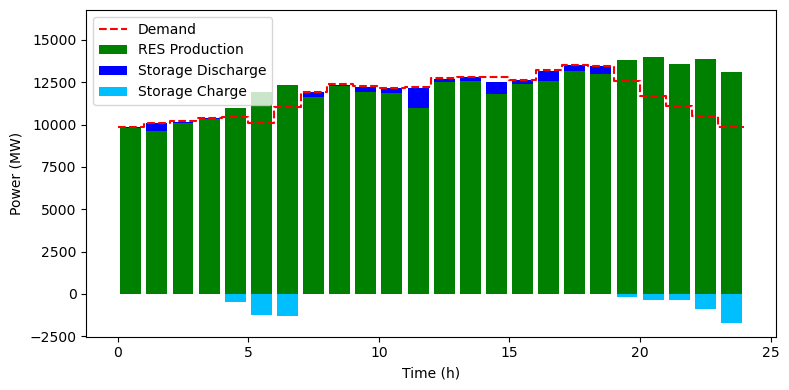

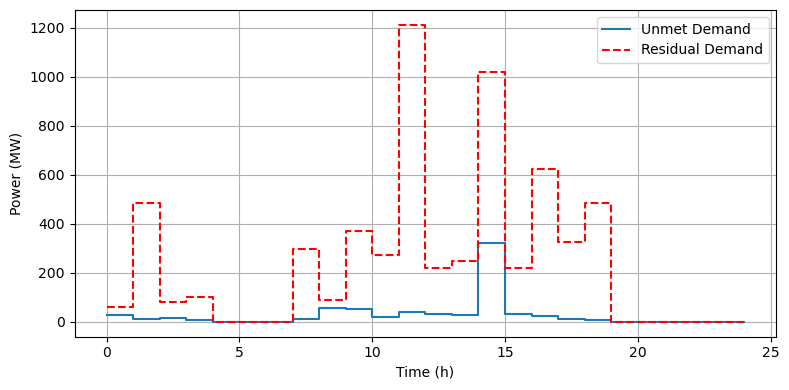

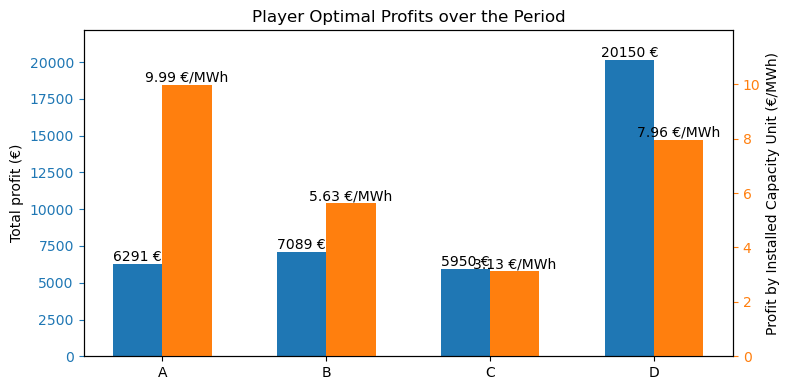

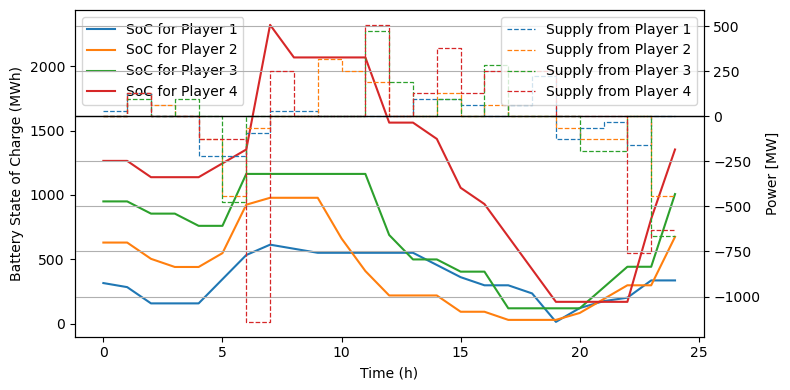

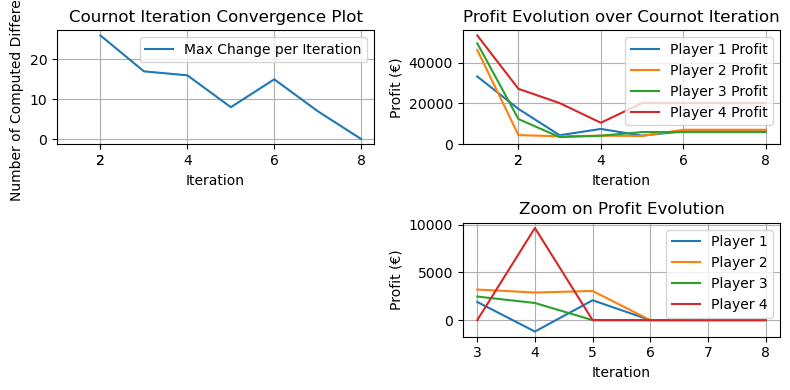


Optimization with modelling policy: flat_tariff
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   630.0   316.0   
1      B  0.5  0.85  1260.0   633.0   
2      C  0.5  0.85  1900.0   950.0   
3      D  0.5  0.85  2530.0  1267.0   

                                             Q_steps  
0  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
1  [0.0, 63.3, 126.6, 189.9, 253.2, 316.5, 379.8,...  
2  [0.0, 95.0, 190.0, 285.0, 380.0, 475.0, 570.0,...  
3  [0.0, 126.7, 253.4, 380.1, 506.8, 633.5, 760.2...  
Optimization was successful. It converged in 8 iterations.


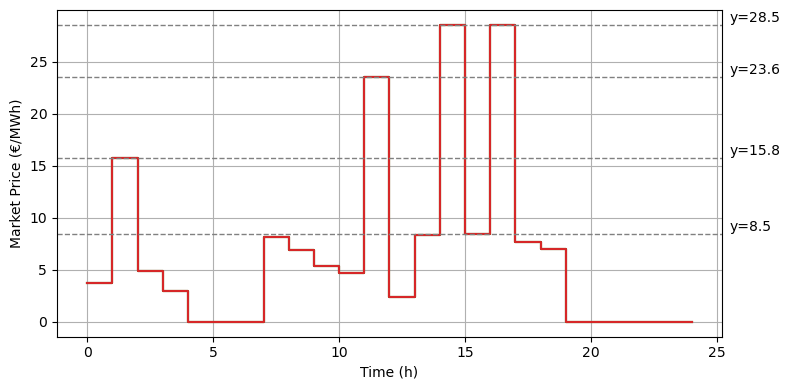

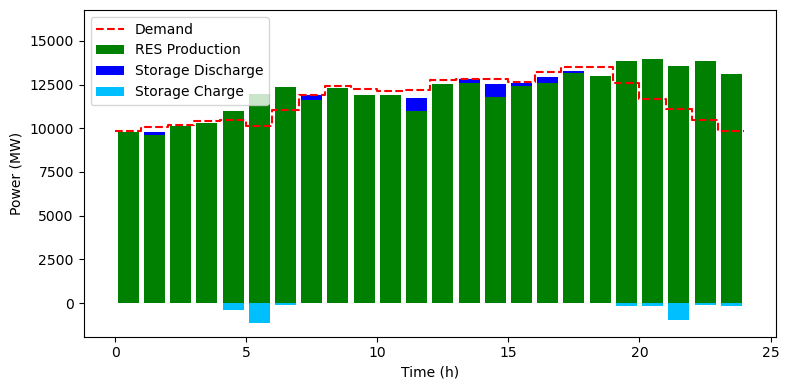

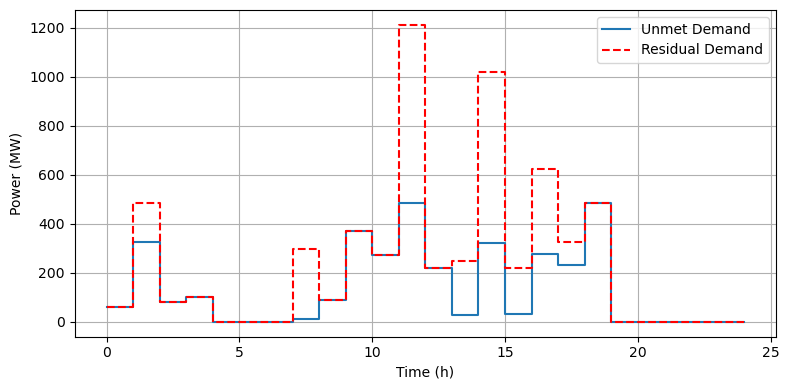

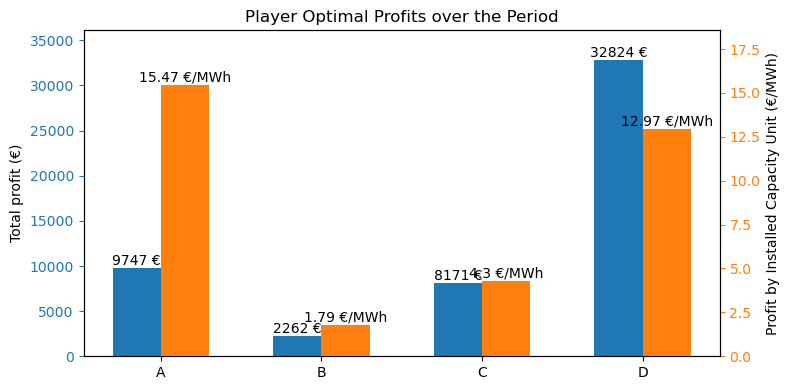

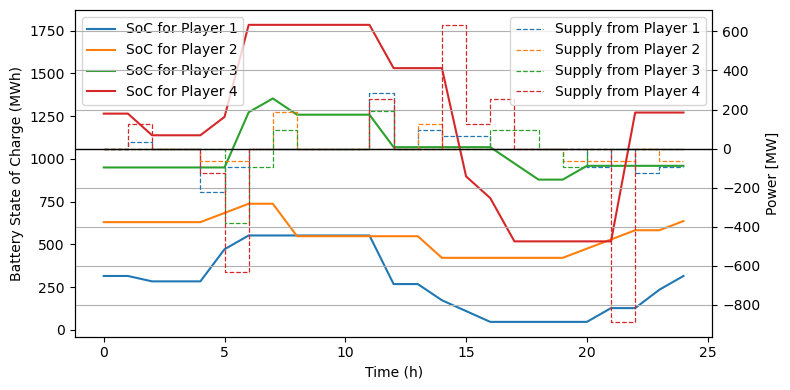

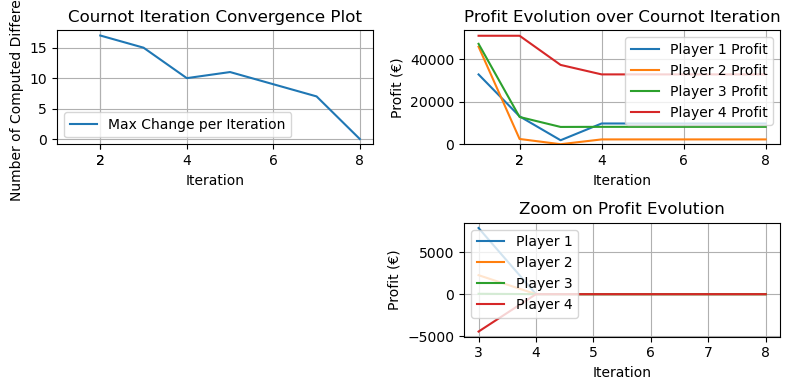


Optimization with modelling policy: hourly_tariff
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   630.0   316.0   
1      B  0.5  0.85  1260.0   633.0   
2      C  0.5  0.85  1900.0   950.0   
3      D  0.5  0.85  2530.0  1267.0   

                                             Q_steps  
0  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
1  [0.0, 63.3, 126.6, 189.9, 253.2, 316.5, 379.8,...  
2  [0.0, 95.0, 190.0, 285.0, 380.0, 475.0, 570.0,...  
3  [0.0, 126.7, 253.4, 380.1, 506.8, 633.5, 760.2...  
Optimization was successful. It converged in 5 iterations.


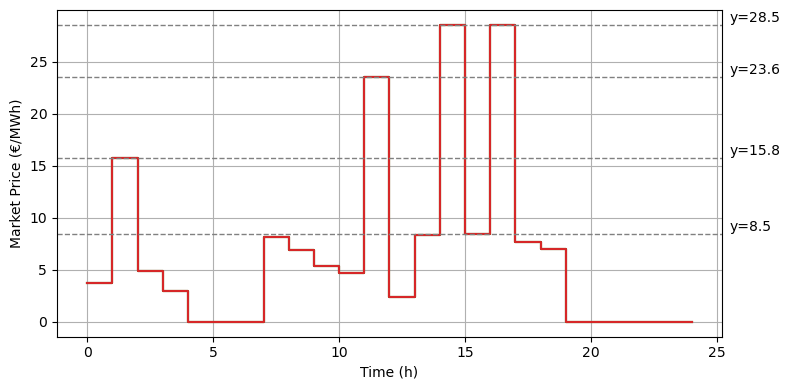

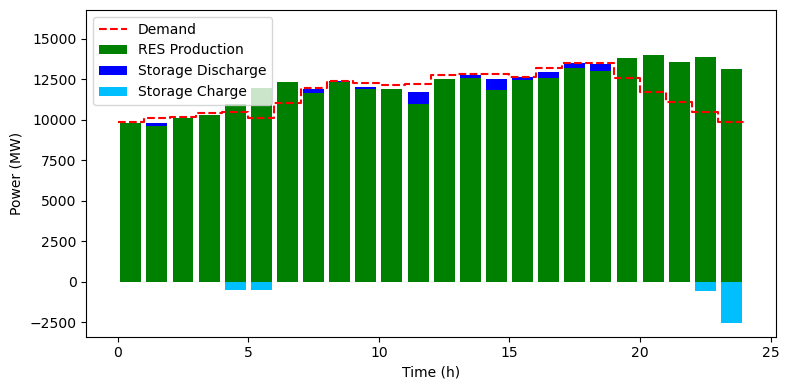

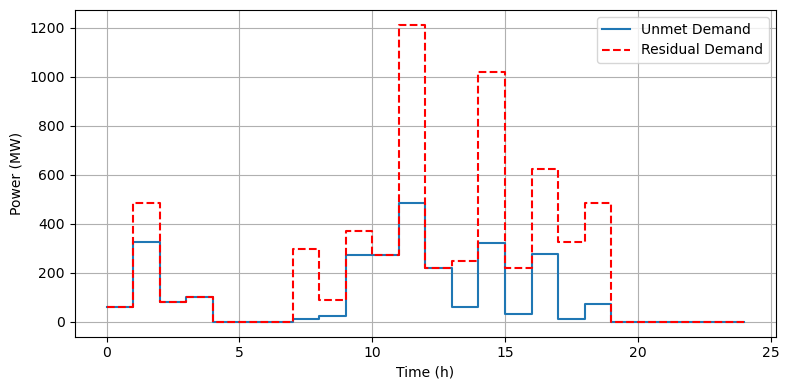

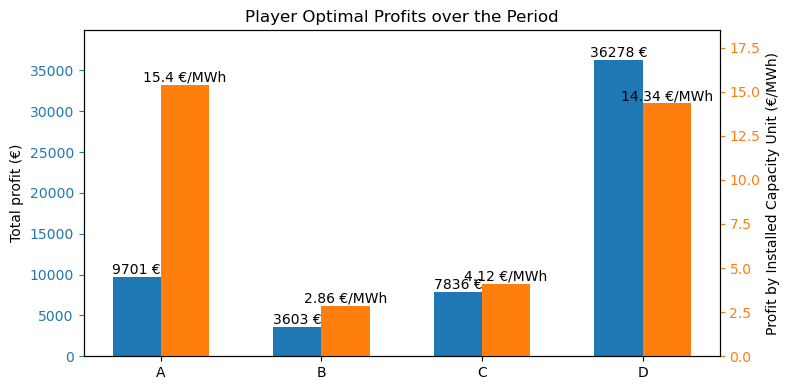

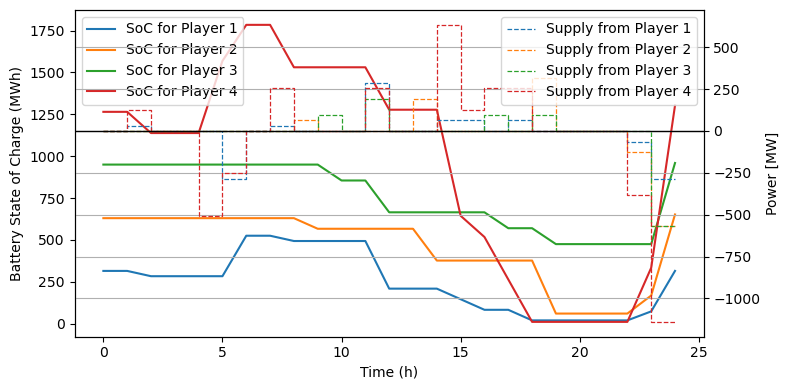

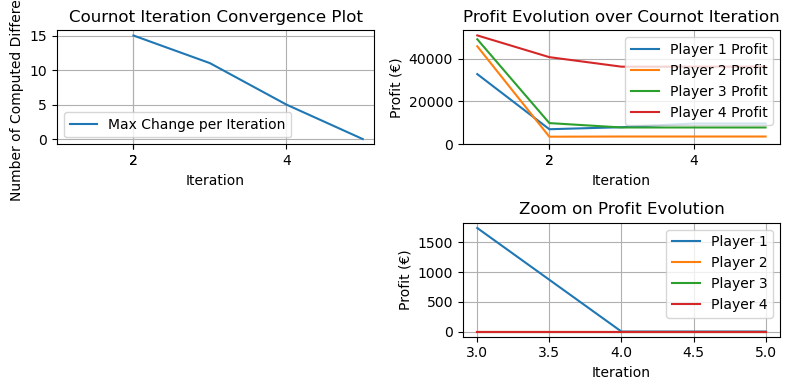


Optimization with modelling policy: dynamic_tariff
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   630.0   316.0   
1      B  0.5  0.85  1260.0   633.0   
2      C  0.5  0.85  1900.0   950.0   
3      D  0.5  0.85  2530.0  1267.0   

                                             Q_steps  
0  [0.0, 31.6, 63.2, 94.8, 126.4, 158.0, 189.6, 2...  
1  [0.0, 63.3, 126.6, 189.9, 253.2, 316.5, 379.8,...  
2  [0.0, 95.0, 190.0, 285.0, 380.0, 475.0, 570.0,...  
3  [0.0, 126.7, 253.4, 380.1, 506.8, 633.5, 760.2...  
Convergence has not been reached. Let's try again by fixing player A outputs.
Optimization was successful. It converged in 202 iterations.


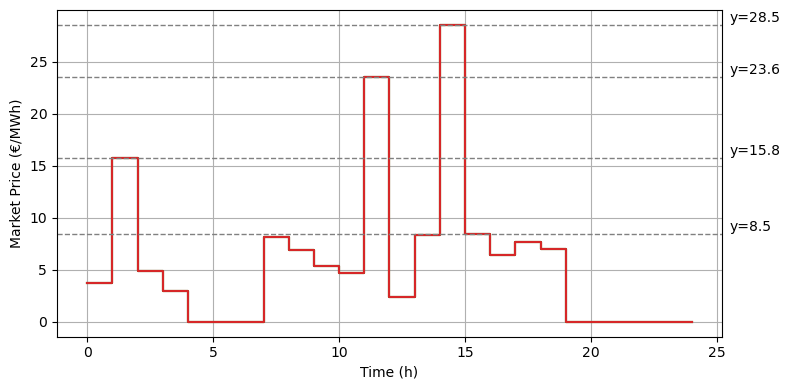

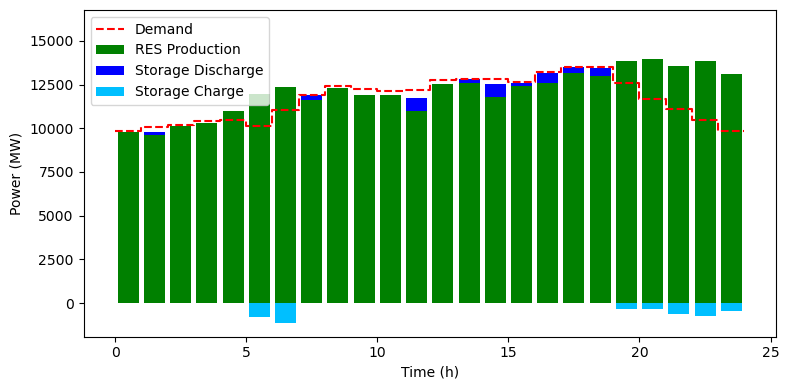

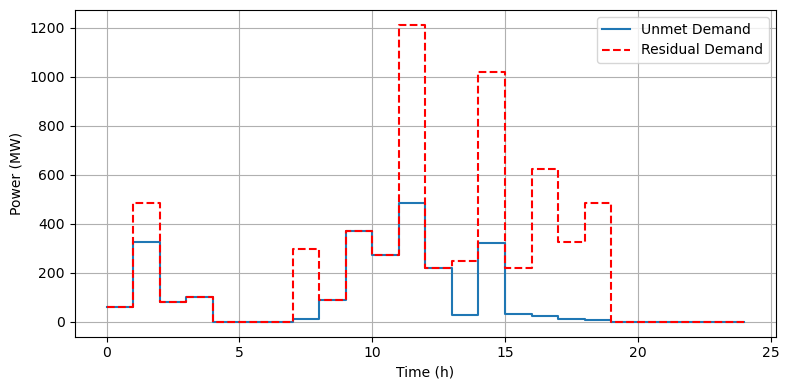

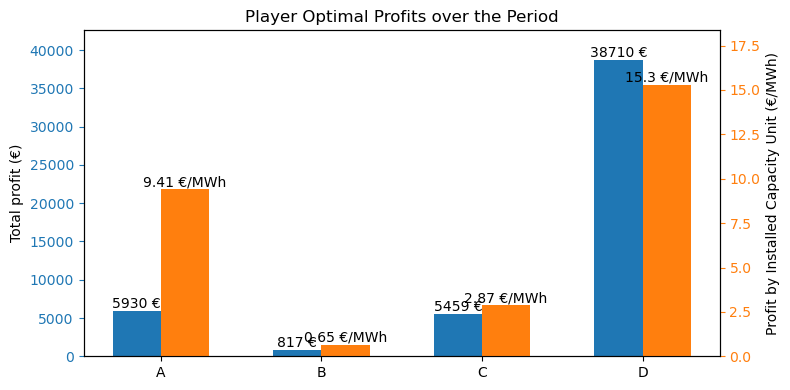

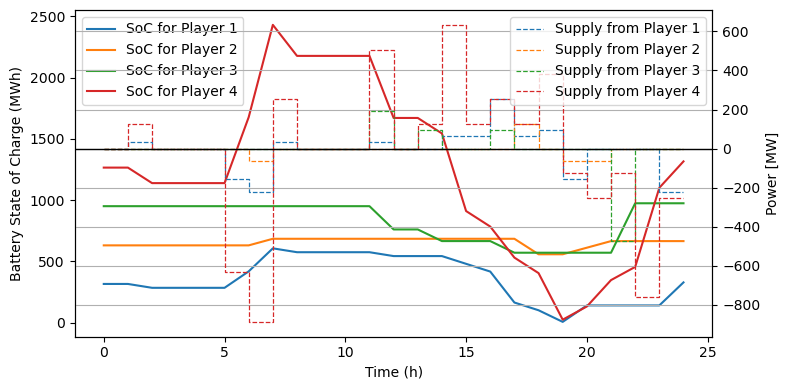

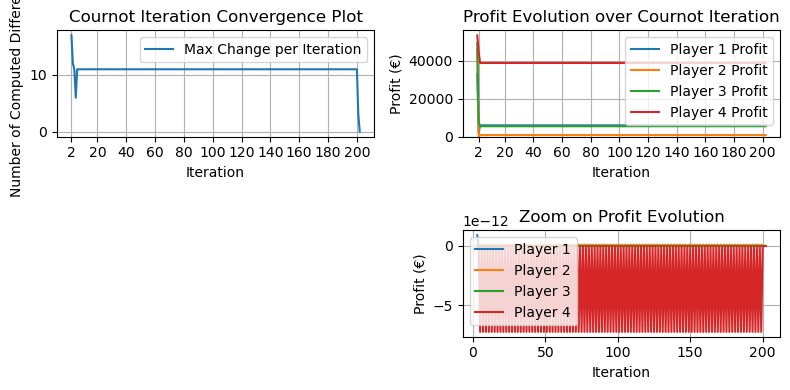

In [13]:
season = "Winter"
scenarios[2]["season"] = season

outputs_winter = {}

for i, scen in enumerate(scenarios):
    print("\nOptimization with modelling policy:", scen["name"])
    outputs_winter[scen["name"]] = main(season=season, plots=True, policy_type=scen["policy_type"], policy_parameters={k: v for k, v in scen.items() if k != "name" and k != "policy_type"})

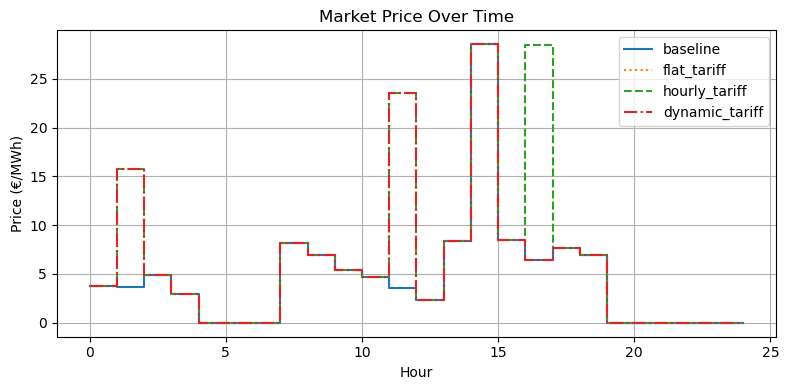

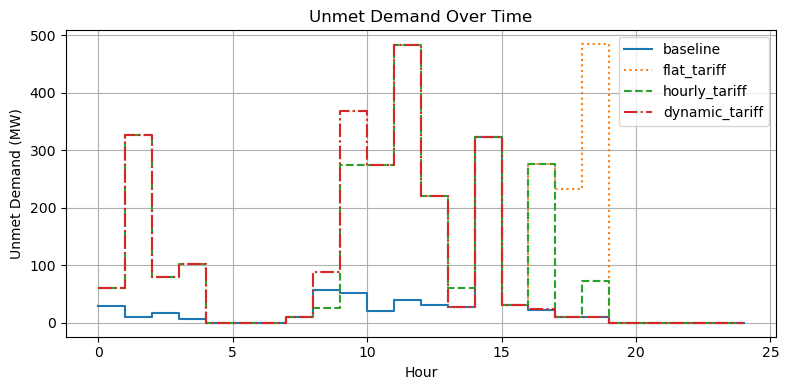

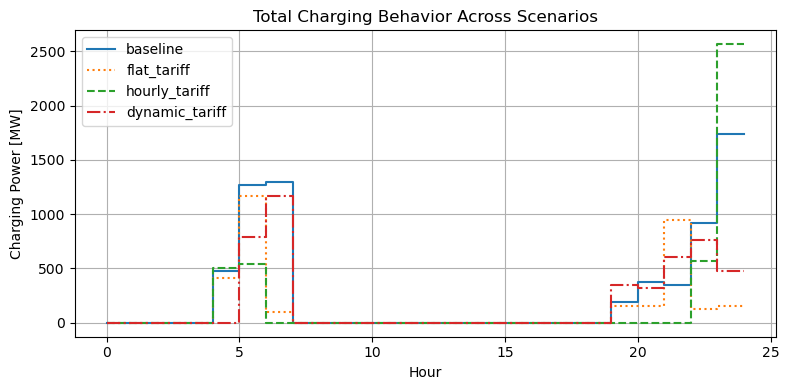

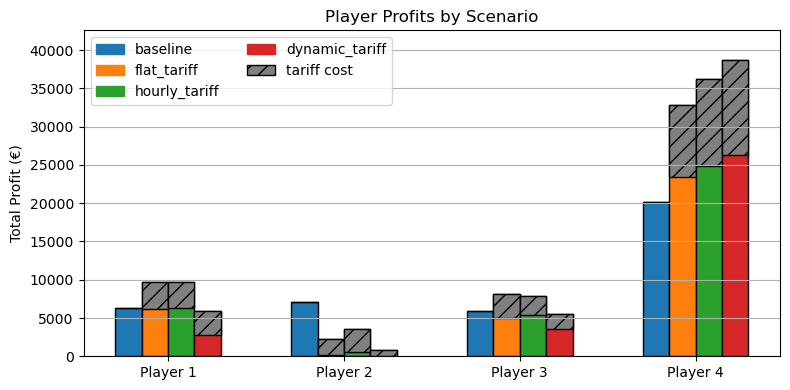

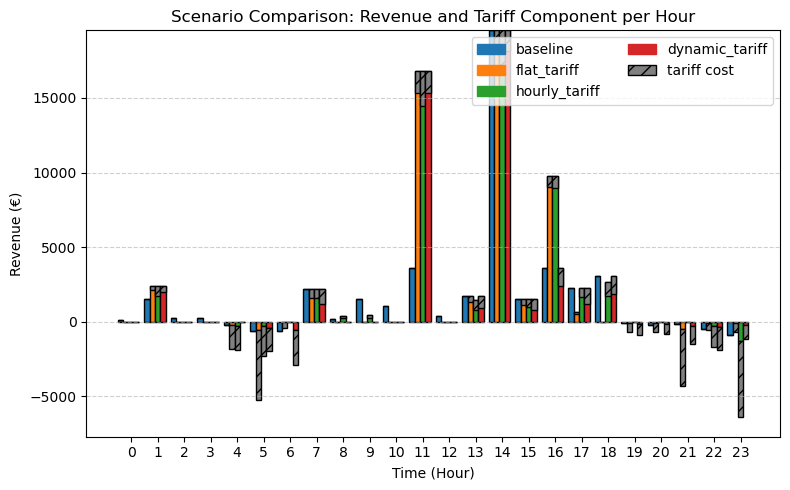

In [21]:
# Compararison of tariffs policies - 4 players - Winter
plot_scenarios_analysis(outputs_winter, plots=True)


## Summer Scenario

In [15]:
season = "Summer"
scenarios[2]["season"] = season

outputs = {}

for i, scen in enumerate(scenarios):
    print("\nOptimization with modelling policy:", scen["name"])
    outputs[scen["name"]] = main(season=season, plots=False, policy_type=scen["policy_type"], policy_parameters={k: v for k, v in scen.items() if k != "name" and k != "policy_type"})


Optimization with modelling policy: baseline
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85  1150.0   576.0   
1      B  0.5  0.85  2300.0  1152.0   
2      C  0.5  0.85  3450.0  1728.0   
3      D  0.5  0.85  4600.0  2304.0   

                                             Q_steps  
0  [0.0, 57.6, 115.2, 172.8, 230.4, 288.0, 345.6,...  
1  [0.0, 115.2, 230.4, 345.6, 460.8, 576.0, 691.2...  
2  [0.0, 172.8, 345.6, 518.4, 691.2, 864.0, 1036....  
3  [0.0, 230.4, 460.8, 691.2, 921.6, 1152.0, 1382...  
Optimization was successful. It converged in 7 iterations.

Optimization with modelling policy: flat_tariff
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85  1150.0   576.0   
1      B  0.5  0.85  2300.0  1152.0   
2      C  0.5  0.85  3450.0  1728.0   
3      D  0.5  0.85  4600.0  2304.0   

                                             Q_steps  
0  [0.0, 57.6, 115.2, 172.8, 230.4, 288.0, 345.6,...  
1  [0.0, 115.2, 230.4, 345.6, 460.8, 576.0, 691.2...  
2  [0.0, 172.8

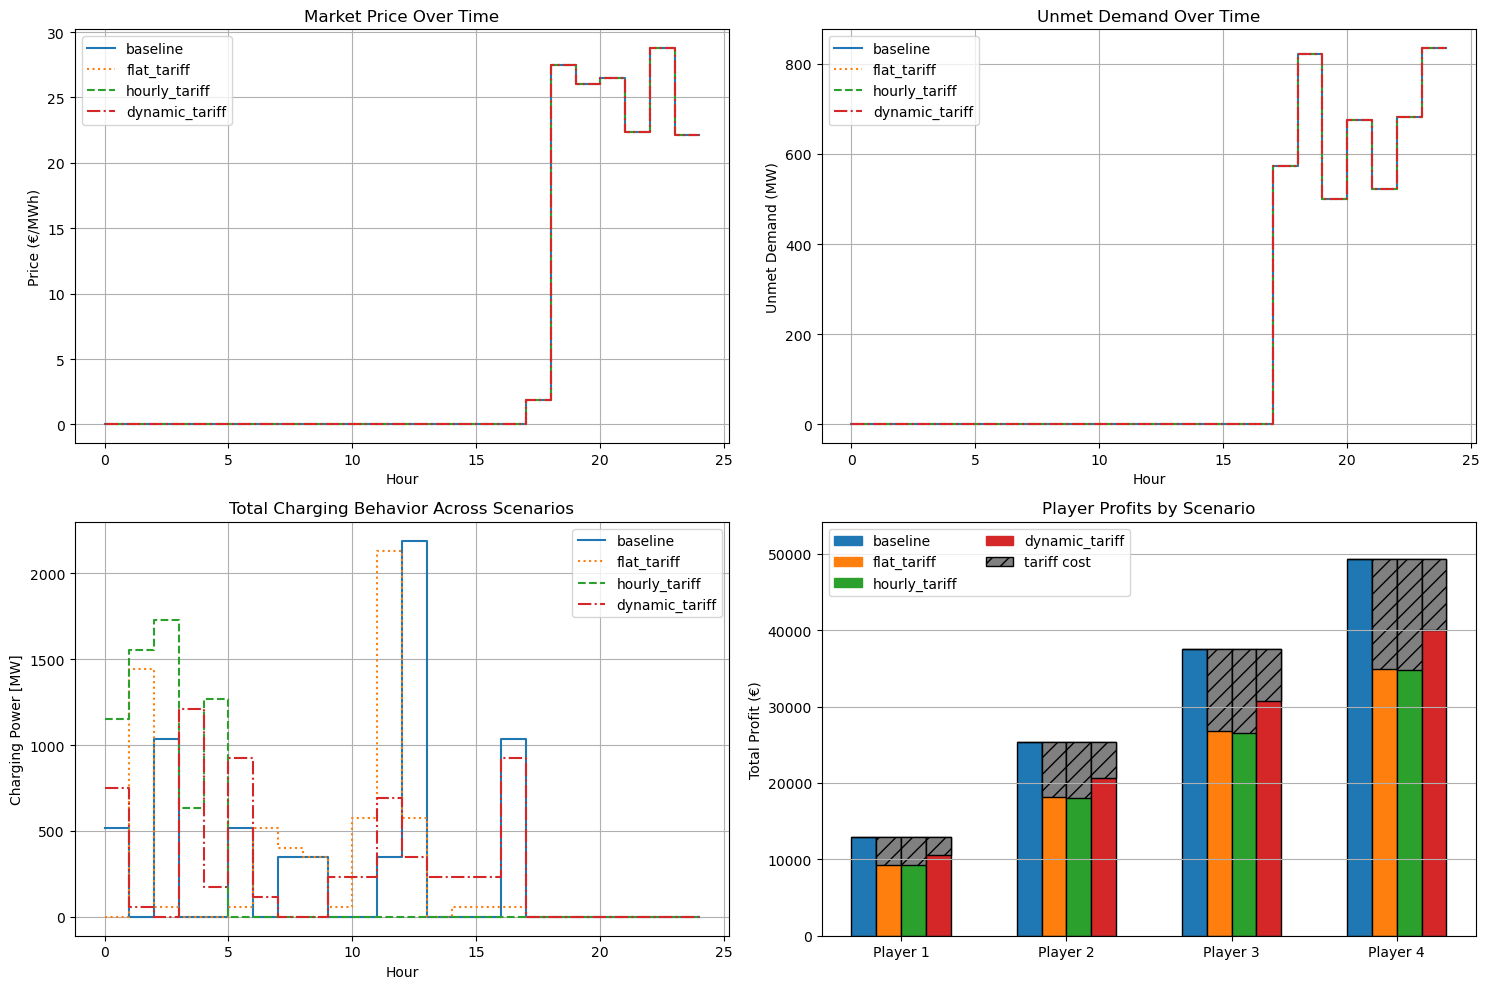

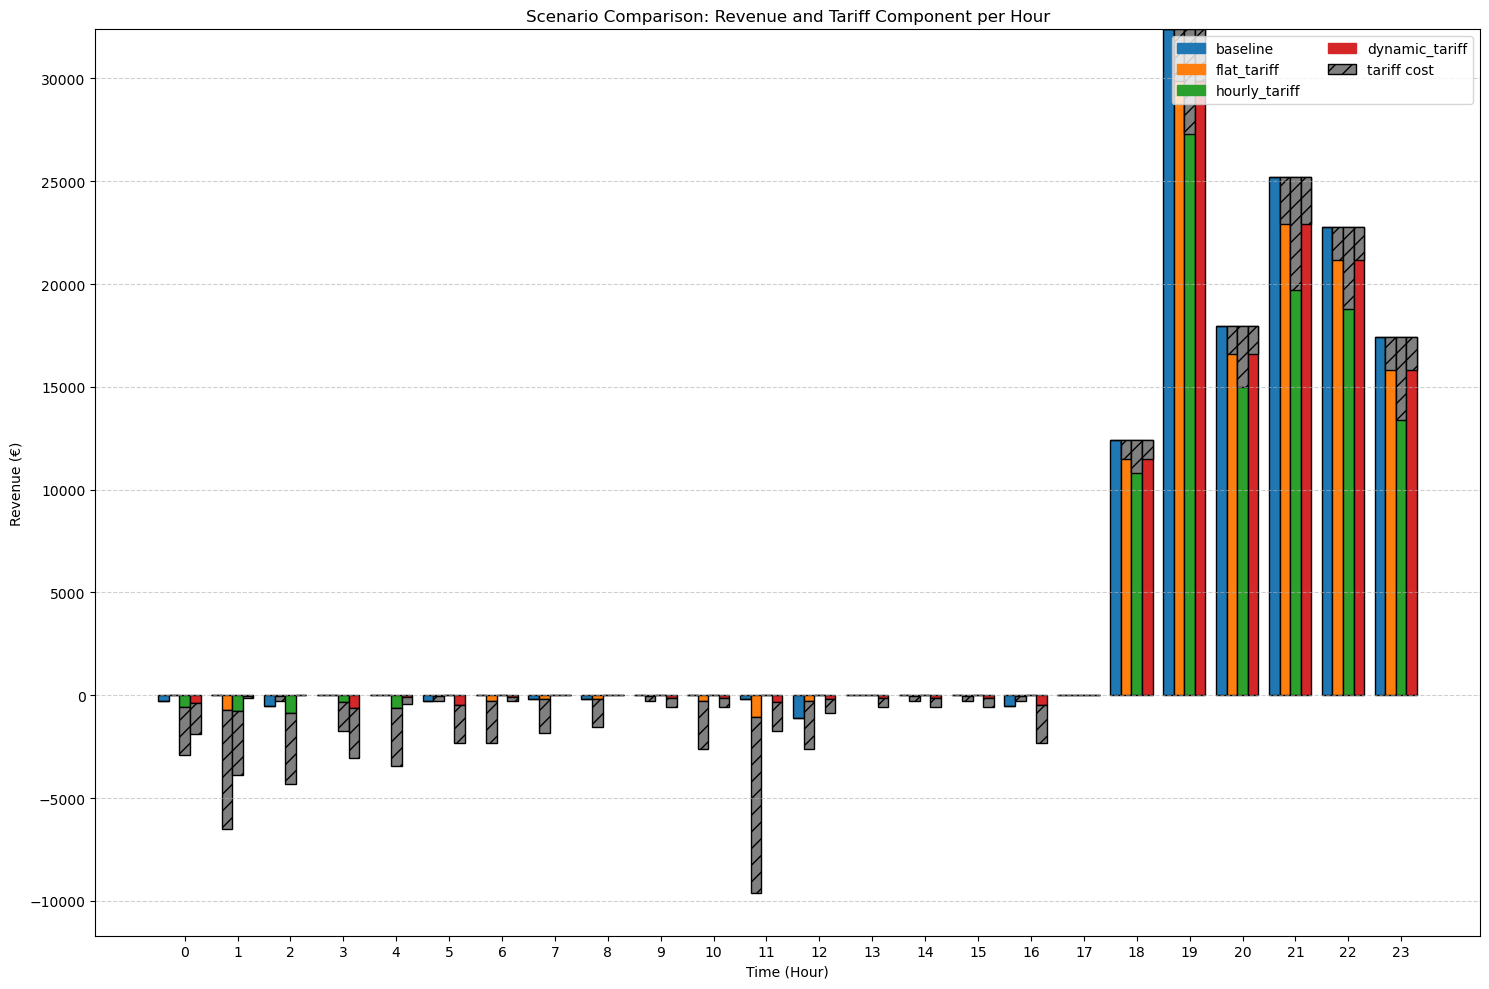

In [16]:
plot_scenarios_analysis(outputs)

## Low Load Scenario

In [17]:
season = "LowLoad"
scenarios[2]["season"] = season

outputs = {}

for i, scen in enumerate(scenarios):
    print("\nOptimization with modelling policy:", scen["name"])
    outputs[scen["name"]] = main(season=season, plots=False, policy_type=scen["policy_type"], policy_parameters={k: v for k, v in scen.items() if k != "name" and k != "policy_type"})


Optimization with modelling policy: baseline
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   910.0   457.0   
1      B  0.5  0.85  1820.0   914.0   
2      C  0.5  0.85  2740.0  1371.0   
3      D  0.5  0.85  3650.0  1828.0   

                                             Q_steps  
0  [0.0, 45.7, 91.4, 137.1, 182.8, 228.5, 274.2, ...  
1  [0.0, 91.4, 182.8, 274.2, 365.6, 457.0, 548.4,...  
2  [0.0, 137.1, 274.2, 411.3, 548.4, 685.5, 822.6...  
3  [0.0, 182.8, 365.6, 548.4, 731.2, 914.0, 1096....  
Convergence has not been reached. Let's try again by fixing player A outputs.
Convergence has not been reached. Let's try again by fixing player B outputs.
Optimization was successful. It converged in 221 iterations.

Optimization with modelling policy: flat_tariff
  Player   OC   Eta   E_max   Q_max  \
0      A  0.5  0.85   910.0   457.0   
1      B  0.5  0.85  1820.0   914.0   
2      C  0.5  0.85  2740.0  1371.0   
3      D  0.5  0.85  3650.0  1828.0   

                     

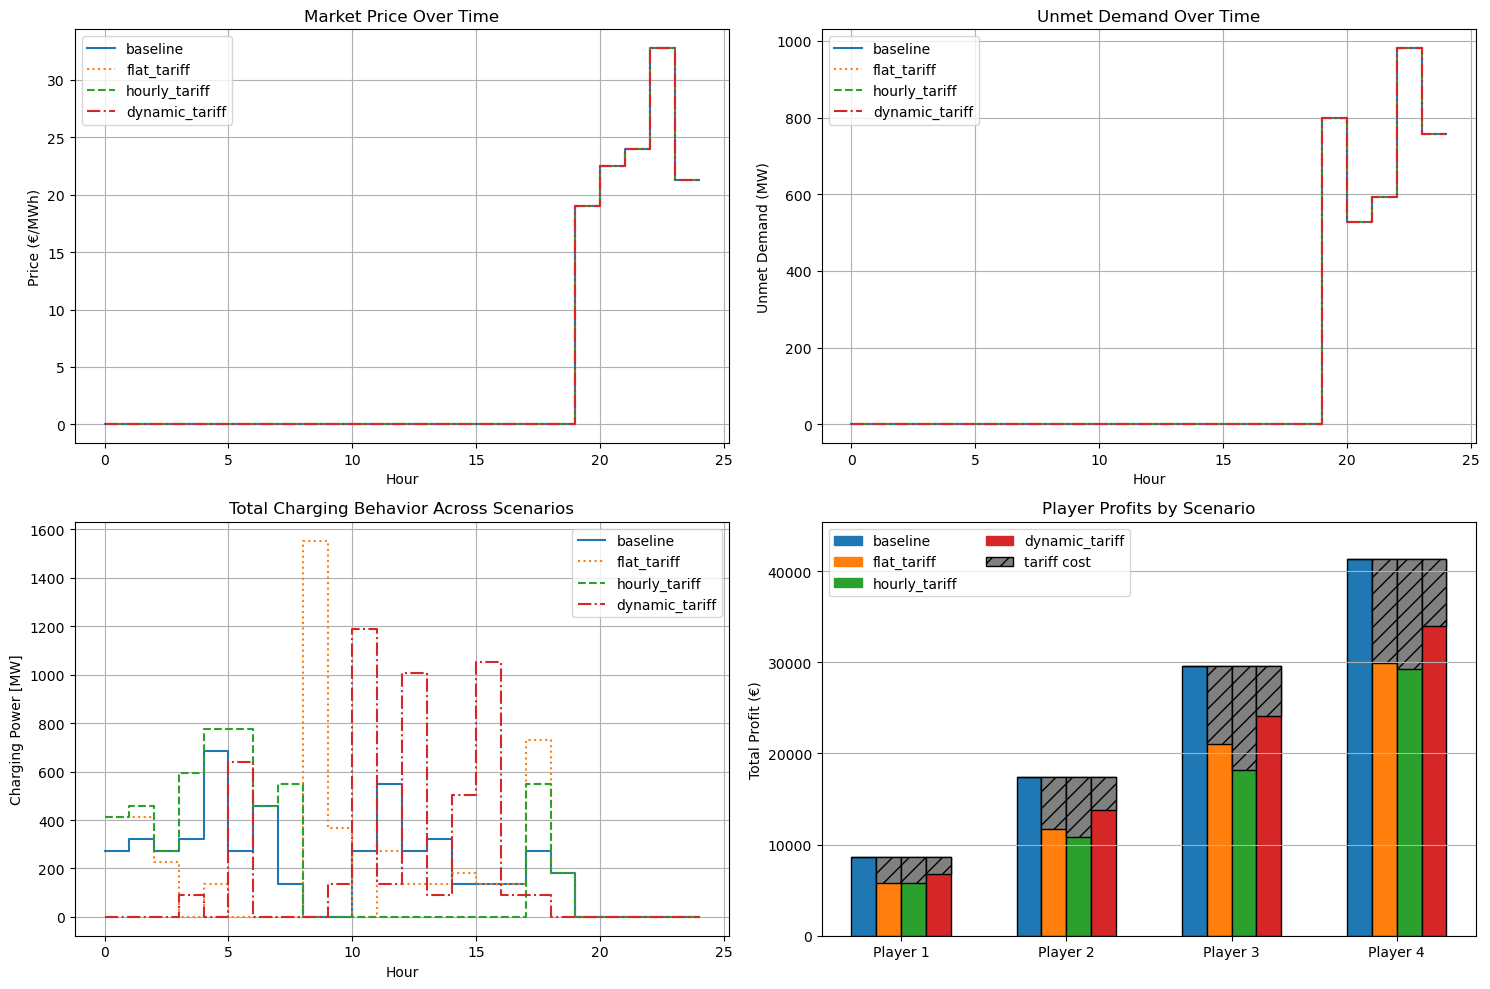

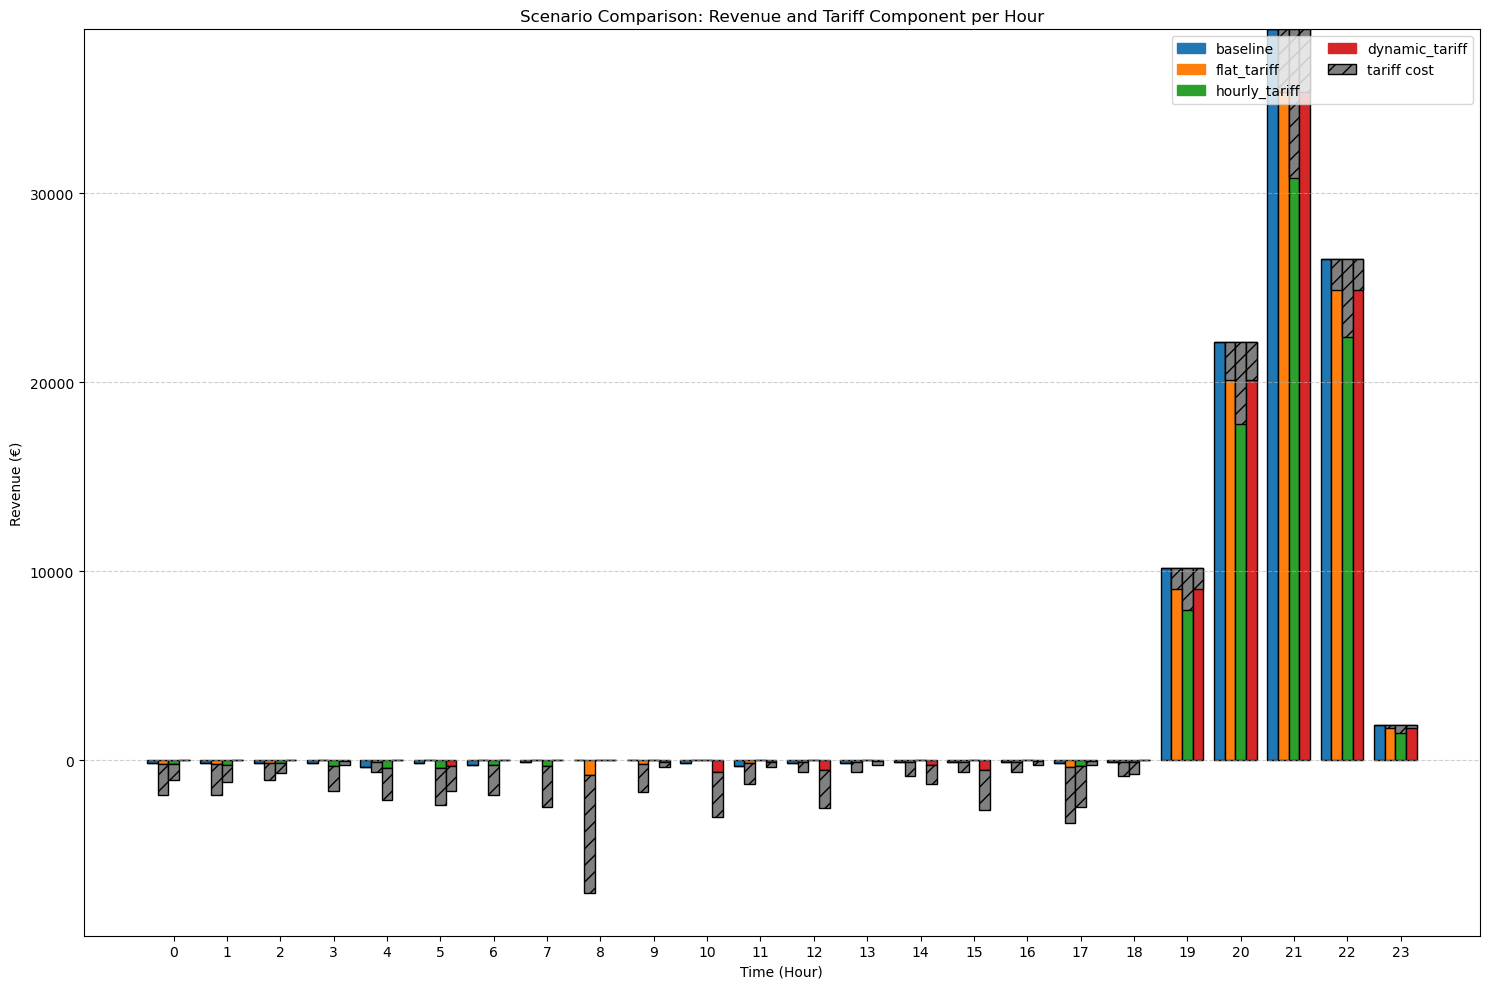

In [18]:
plot_scenarios_analysis(outputs)